### Moive Recommendation Using PySpark DataFrame and RDD in Databricks
In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark 'MLlib' APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [3]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [6]:
movies = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratings = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
links = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tags = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)

In [7]:
movies.show(5)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

In [8]:
ratings.show(5)

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
 1| 50| 5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

In [9]:
links.show(5)

+-------+-------+------+
movieId| imdbId|tmdbId|
+-------+-------+------+
 1|0114709| 862|
 2|0113497| 8844|
 3|0113228| 15602|
 4|0114885| 31357|
 5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows

In [10]:
movies.printSchema()
ratings.printSchema()
links.printSchema()

root
-- movieId: string (nullable = true)
-- title: string (nullable = true)
-- genres: string (nullable = true)

root
-- userId: string (nullable = true)
-- movieId: string (nullable = true)
-- rating: string (nullable = true)
-- timestamp: string (nullable = true)

root
-- movieId: string (nullable = true)
-- imdbId: string (nullable = true)
-- tmdbId: string (nullable = true)

In [11]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}.'.format(tmp1))
print('Minimum number of ratings per movie is {}.'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20.
Minimum number of ratings per movie is 1.

In [12]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user.'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user.

## Part 1: Spark SQL and OLAP

### Q1: The number of Users

In [15]:
num_of_users = ratings.select("userID").distinct().count()
print("The number of users is {}.".format(num_of_users))

The number of users is 610.

### Q2: The number of Movies

In [17]:
num_of_movies = movies.select("movieID").distinct().count()
print("The number of movies is {}.".format(num_of_movies))

The number of movies is 9742.

### Q3:  How many movies are rated by users? List movies not rated before

In [19]:
ratings = ratings.dropna(subset=["rating"])
num_of_rated_movies = ratings.select("movieID").distinct().count()
print("There are {} movies that have been rated by users.".format(num_of_rated_movies))

There are 9724 movies that have been rated by users.

In [20]:
from pyspark.sql.functions import col

tmp = movies.join(ratings.where(col("rating").isNull()), "movieID")
not_rated = tmp.select("title")
not_rated.show(5)

+-----+
title|
+-----+
+-----+

### Q4: List Movie Genres

In [22]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType

@udf(ArrayType(StringType()))
def splitUdf(x):
    splitted = x.split('|')
    return [i for i in splitted]

dfv = movies.withColumn('genres', splitUdf(col('genres'))) \
     .select(col('movieID'), col('title'), col('genres'))
dfv.show(5)

+-------+--------------------+--------------------+
movieID| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|[Adventure, Anima...|
 2| Jumanji (1995)|[Adventure, Child...|
 3|Grumpier Old Men ...| [Comedy, Romance]|
 4|Waiting to Exhale...|[Comedy, Drama, R...|
 5|Father of the Bri...| [Comedy]|
+-------+--------------------+--------------------+
only showing top 5 rows

In [23]:
from pyspark.sql.functions import explode
df_genre = dfv.withColumn("genres", explode("genres"))
distinct_df_genre = df_genre.select("genres").distinct()
distinct_df_genre.show(20)

+------------------+
 genres|
+------------------+
 Crime|
 Romance|
 Thriller|
 Adventure|
 Drama|
 War|
 Documentary|
 Fantasy|
 Mystery|
 Musical|
 Animation|
 Film-Noir|
(no genres listed)|
 IMAX|
 Horror|
 Western|
 Comedy|
 Children|
 Action|
 Sci-Fi|
+------------------+

In [24]:
genre_count = distinct_df_genre.count()
print("The total number of genres is {}.".format(genre_count))

The total number of genres is 20.

### Q5: Movie for Each Category

In [26]:
#df_genre.filter(df_genre.genres != "(no genres listed)").show()

In [27]:
import pyspark.sql.functions as f
df_genre = df_genre.groupby("genres").agg(f.concat_ws(", ", f.collect_list(df_genre.title)))
display(df_genre)

genres concat_ws(, , collect_list(title)) Crime Heat (1995), Casino (1995), Money Train (1995), Get Shorty (1995), Copycat (1995), Assassins (1995), Shanghai Triad (Yao a yao yao dao waipo qiao) (1995), Dead Man Walking (1995), Dead Presidents (1995), Usual Suspects, The (1995), Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996), Crossing Guard, The (1995), Things to Do in Denver When You're Dead (1995), Hate (Haine, La) (1995), Bottle Rocket (1996), Taxi Driver (1976), Rumble in the Bronx (Hont faan kui) (1995), Young Poisoner's Handbook, The (1995), Bad Boys (1995), Amateur (1994), Batman Forever (1995), Clockers (1995), Devil in a Blue Dress (1995), Die Hard: With a Vengeance (1995), Doom Generation, The (1995), Hackers (1995), Judge Dredd (1995), Net, The (1995), Strange Days (1995), Bushwhacked (1995), Heavenly Creatures (1994), Kiss of Death (1995), New Jersey Drive (1995), New York Cop (Nyû Yôku no koppu) (1993), Natural Born Killers (1994), Once Were Warriors (1994), Léon: The Professional (a.k.a. The Professional) (Léon) (1994), Pulp Fiction (1994), Shawshank Redemption, The (1994), Tales from the Hood (1995), Clear and Present Danger (1994), Crow, The (1994), Mask, The (1994), Bad Company (1995), Faster Pussycat! Kill! Kill! (1965), Jason's Lyric (1994), Above the Rim (1994), Beverly Hills Cop III (1994), Carlito's Way (1993), Fresh (1994), Getaway, The (1994), Hard Target (1993), Jimmy Hollywood (1994), Judgment Night (1993), Killing Zoe (1994), Menace II Society (1993), Perfect World, A (1993), RoboCop 3 (1993), Romeo Is Bleeding (1993), Serial Mom (1994), Striking Distance (1993), True Romance (1993), Escort, The (Scorta, La) (1993), Batman (1989), Silence of the Lambs, The (1991), Love and a .45 (1994), Fargo (1996), Primal Fear (1996), Courage Under Fire (1996), Substitute, The (1996), Mulholland Falls (1996), Heaven's Prisoners (1996), Striptease (1996), Trainspotting (1996), American Buffalo (1996), Ransom (1996), Godfather, The (1972), Supercop (Police Story 3: Supercop) (Jing cha gu shi III: Chao ji jing cha) (1992), Bound (1996), Carpool (1996), Kansas City (1996), Nothing to Lose (1994), Supercop 2 (Project S) (Chao ji ji hua) (1993), Bulletproof (1996), Some Like It Hot (1959), Charade (1963), To Catch a Thief (1955), Laura (1944), Thin Man, The (1934), Beat the Devil (1953), Last Man Standing (1996), Set It Off (1996), 2 Days in the Valley (1996), Freeway (1996), Die Hard (1988), Normal Life (1996), Crossfire (1947), Fish Called Wanda, A (1988), Bonnie and Clyde (1967), Dial M for Murder (1954), Reservoir Dogs (1992), Basic Instinct (1992), Funeral, The (1996), Return of the Pink Panther, The (1975), Wallace & Gromit: The Wrong Trousers (1993), Grifters, The (1990), Tie Me Up! Tie Me Down! (¡Átame!) (1990), Clockwork Orange, A (1971), Goodfellas (1990), Killer, The (Die xue shuang xiong) (1989), Psycho (1960), Godfather: Part II, The (1974), Once Upon a Time in America (1984), Sting, The (1973), Miller's Crossing (1990), Touch of Evil (1958), Femme Nikita, La (Nikita) (1990), Chinatown (1974), M (1931), Manchurian Candidate, The (1962), Fried Green Tomatoes (1991), Big Sleep, The (1946), Cape Fear (1962), Blood and Wine (Blood & Wine) (1996), Albino Alligator (1996), Batman Returns (1992), Sneakers (1992), Beavis and Butt-Head Do America (1996), La Cérémonie (1995), Hamlet (1996), Thieves (Voleurs, Les) (1996), Murder at 1600 (1997), Metro (1997), Gridlock'd (1997), Lost Highway (1997), Donnie Brasco (1997), Best Men (1997), Grosse Pointe Blank (1997), Face/Off (1997), Cop Land (1997), Desperate Measures (1998), Hoodlum (1997), L.A. Confidential (1997), Kiss the Girls (1997), U Turn (1997), Playing God (1997), Switchback (1997), Gang Related (1997), Deceiver (1997), Incognito (1997), Red Corner (1997), Man Who Knew Too Little, The (1997), Midnight in the Garden of Good and Evil (1997), Jackie Brown (1997), Big Lebowski, The (1998), Hard Rain (1998), Fallen (1998), Replacement

## Part2: Spark ALS based approach for training model
We will use an RDD-based API from [pyspark.mllib](https://spark.apache.org/docs/2.1.1/mllib-collaborative-filtering.html) to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

### Please refer to Spark ML ALS model
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/4999972933037924/899848065201823/8135547933712821/latest.html

In [29]:
from pyspark.mllib.recommendation import ALS, Rating #this is different from the pyspark.ml.recommendation library
import math

In [30]:
#from pyspark import SparkConf
from pyspark.context import SparkContext

#sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
movie_rating = sc.textFile("/FileStore/tables/ratings.csv")

In [31]:
header = movie_rating.take(1)[0]
#convert to tuples
rating_data = movie_rating.filter(lambda line: line!=header).map(lambda line: line.split(",")).map(lambda tokens: (tokens[0],tokens[1],tokens[2])).cache()

In [32]:
# check three rows
rating_data.take(3)

Out[ 699 ]: [('1', '1', '4.0'), ('1', '3', '4.0'), ('1', '6', '4.0')]

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [34]:
training_RDD, validation_RDD, test_RDD = rating_data.randomSplit([6, 2, 2], seed = 774)

Prepare userID and movieID columns for the use of making predictions.

In [36]:
validation_for_predict_RDD = validation_RDD.map(lambda x: (x[0], x[1]))
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

In [37]:
training_RDD.cache()

Out[ 702 ]: PythonRDD[6134] at RDD at PythonRDD.scala:56

In [38]:
validation_RDD.cache()

Out[ 703 ]: PythonRDD[6135] at RDD at PythonRDD.scala:56

In [39]:
test_RDD.cache()

Out[ 704 ]: PythonRDD[6136] at RDD at PythonRDD.scala:56

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [41]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_params:
            #train ALS model using pyspark.mllib.recommendation - RDD-based API
            model = ALS.train(training_RDD, rank, seed = 774, iterations = num_iters,
                              lambda_ = reg)
            #make predictions
            predictions = model.predictAll(validation_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
            #get the rating result
            rates_and_preds = validation_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
            #get the RMSE /(error) of cross validation data
            cv_error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
            print ('{} latent factors and regularization = {}: validation RMSE is {:.4f}'.format(rank, reg, cv_error)) 
            if cv_error < min_error:
                min_error = cv_error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\nThe best model was trained with {} which has {} latent factors. \nRegularization parameter = {}'.format(best_rank, best_rank, best_regularization))
    return best_model

In [42]:
num_iterations = 10   #How many times will be iterate over the data
ranks = [6, 8, 10, 12, 14]   #Creates a list of latent factors, experiement with each
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]   #Test with regularization parameter

import time
start_time = time.time()
final_model = train_ALS(training_RDD, validation_for_predict_RDD, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 0.97370770831362
6 latent factors and regularization = 0.1: validation RMSE is 0.9092574081452132
6 latent factors and regularization = 0.2: validation RMSE is 0.8906800338207467
6 latent factors and regularization = 0.4: validation RMSE is 0.9580028098912708
6 latent factors and regularization = 0.8: validation RMSE is 1.174888795606392
8 latent factors and regularization = 0.05: validation RMSE is 0.9800744810685856
8 latent factors and regularization = 0.1: validation RMSE is 0.905522539580998
8 latent factors and regularization = 0.2: validation RMSE is 0.8866885981953596
8 latent factors and regularization = 0.4: validation RMSE is 0.9571987255204922
8 latent factors and regularization = 0.8: validation RMSE is 1.1749003191667098
10 latent factors and regularization = 0.05: validation RMSE is 0.9928169192787994
10 latent factors and regularization = 0.1: validation RMSE is 0.9105033458616681
10 latent factors and regularization = 0.2: validation RMSE is 0.8884289828901778
10 latent factors and regularization = 0.4: validation RMSE is 0.9575079822844805
10 latent factors and regularization = 0.8: validation RMSE is 1.1749235324519982
12 latent factors and regularization = 0.05: validation RMSE is 1.0016375316159982
12 latent factors and regularization = 0.1: validation RMSE is 0.9113528742828918
12 latent factors and regularization = 0.2: validation RMSE is 0.8879895279364602
12 latent factors and regularization = 0.4: validation RMSE is 0.9567486281379353
12 latent factors and regularization = 0.8: validation RMSE is 1.1749152582788114
14 latent factors and regularization = 0.05: validation RMSE is 0.9913271583290335
14 latent factors and regularization = 0.1: validation RMSE is 0.905869545425794
14 latent factors and regularization = 0.2: validation RMSE is 0.8887204312478574
14 latent factors and regularization = 0.4: validation RMSE is 0.957507271015921
14 latent factors and regularization = 0.8: validation RMSE is 1.1749111258783598

The best model was trained with 8 which has 8 latent factors. 
Regularization parameter = 0.2
Total Runtime: 191.44 seconds

In [43]:
#apply the final model 
rating_data_for_predict_RDD = rating_data.map(lambda x: (x[0], x[1]))
predictions = final_model.predictAll(rating_data_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = rating_data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
#get X: features
X = rates_and_preds.map(lambda r: (r[0][0], r[0][1], r[1][0]))  
 #get y: target
y = rates_and_preds.map(lambda r: r[1][1])  

In [44]:
X_arr = np.reshape(np.array(X.collect()), (-1, 3))
X_arr.shape

Out[ 708 ]: (98801, 3)

In [45]:
X_df = pd.DataFrame(X_arr, columns = ["userID", "movieID", "rating"])
#X_df = X_df.dropna()
display(X_df)

userID,movieID,rating
489.0,2657.0,4.0
381.0,34319.0,4.0
480.0,440.0,2.5
274.0,1196.0,4.5
437.0,47.0,4.0
139.0,5349.0,3.0
474.0,1408.0,4.0
517.0,955.0,1.0
19.0,2491.0,4.0
152.0,48516.0,3.5


In [46]:
y_arr = np.reshape(np.array(y.collect()), (-1, 1))
y_arr.shape

Out[ 710 ]: (98801, 1)

In [47]:
y_df =  pd.DataFrame(y_arr, columns = ["predicted_rating"])
display(y_df)

predicted_rating
2.9532235753959615
3.4317660522452282
3.037620144122963
3.764698536077821
3.8986114144264166
2.0924074521235374
3.426848727750403
2.2002563587783737
2.0306762545073545
4.093962686778486


#### References of ALS

- Building a Movie Recommendation Service: https://www.codementor.io/jadianes/building-a-recommender-with-apache-spark-python-example-app-part1-du1083qbw
- MLlib - Collaborative Filtering: https://spark.apache.org/docs/1.1.0/mllib-collaborative-filtering.html
- Collaborative Filtering - RDD-based API: https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html
- Evaluation Metrics - RDD-based API: https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html
- ML - ALS: https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1

In [49]:
# Load libraries
from sklearn.linear_model import LinearRegression
from sklearn.learning_curve import learning_curve
import matplotlib.pyplot as plt

In [50]:
X = X_df[["userID", "movieID", "rating"]] #features we train
y = y_df[["predicted_rating"]] #target
cv = 5 #k-fold cross validation
iter_array = [1, 100, 500, 1000] #train_sizes

In [51]:
def plot_learning_curve():
  train_sizes, train_scores, validation_scores = learning_curve( \
                                                                estimator = LinearRegression(), \
                                                                X = X, \
                                                                y = y, \
                                                                cv = cv, \
                                                                scoring = 'neg_mean_squared_error', \
                                                                train_sizes = iter_array \
                                                               )
    
  #calculate mean and std deviation for training and cross validation data
  train_scores_mean = -np.mean(train_scores, axis=1) #use the minus sign to offset negative mean squared error
  train_scores_std = np.std(train_scores, axis=1)
  validation_scores_mean = -np.mean(validation_scores, axis=1) 
  validation_scores_std = np.std(validation_scores, axis=1)
  
  #plot learning curve
  plt.clf() #clear the old figure before plotting a new one
  plt.figure() #create figure object
  plt.style.use('seaborn-whitegrid')
  plt.title('Learning Curves for a Linear Regression Model', fontsize = 18)
  plt.xlabel('Training set size', fontsize = 14)
  plt.ylabel('Score', fontsize = 14)
  
  #plot the std deviation as a transparent range at each training set size
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
  plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
  plt.plot(train_sizes, train_scores_mean, color = "r", label = "Training error")
  plt.plot(train_sizes, validation_scores_mean, color = "g", label = "Cross-validation error")
  plt.legend(labelspacing=0.5, bbox_to_anchor=(1.00, 0.98), fontsize = 12)

  plt.ylim(0, 0.6)
  plt.show()

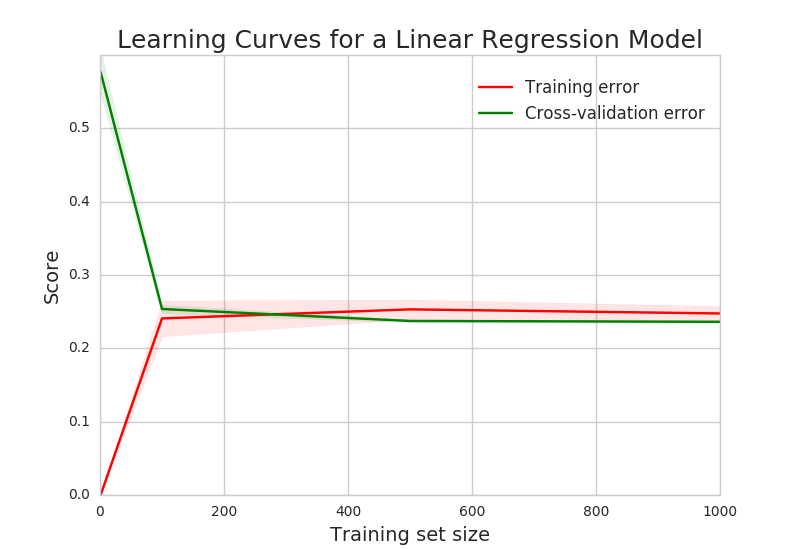

In [52]:
display(plot_learning_curve())

In [53]:
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[-0.22984063 -0.2376753 -0.2376753 -0.2376753 -0.2376753 ]
 [-0.23503251 -0.234812 -0.23382136 -0.23382136 -0.23382136]
 [-0.23658941 -0.23643481 -0.23485046 -0.23522261 -0.23522261]
 [-0.2355575 -0.2354606 -0.23432317 -0.23554746 -0.23606959]
 [-0.23555293 -0.23547314 -0.23459584 -0.23554053 -0.23549491]]

 ----------------------------------------------------------------------

Validation scores:

 [[-0.23486931 -0.23513706 -0.23853929 -0.2350099 -0.23486146]
 [-0.23454275 -0.23481995 -0.2383004 -0.23453657 -0.2346781 ]
 [-0.23447933 -0.2348443 -0.2383188 -0.23451907 -0.234704 ]
 [-0.23448865 -0.23479568 -0.2383269 -0.23452894 -0.23467874]
 [-0.23447305 -0.23479811 -0.23830707 -0.2345304 -0.23468885]]

In [54]:
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) 
print('\nStd deviation training scores\n\n', pd.Series(train_scores_std, index = train_sizes))

Mean training scores

 7904 0.236108
25688 0.234262
43472 0.235664
61256 0.235392
79040 0.235331
dtype: float64

 --------------------

Std deviation training scores

 7904 0.003134
25688 0.000544
43472 0.000707
61256 0.000576
79040 0.000369
dtype: float64

In [55]:
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))
print('\n', '-' * 20) 
print('\nStd deviation validation scores\n\n',pd.Series(validation_scores_std, index = train_sizes))

Mean validation scores

 7904 0.235683
25688 0.235376
43472 0.235373
61256 0.235364
79040 0.235359
dtype: float64

 --------------------

Std deviation validation scores

 7904 0.001432
25688 0.001466
43472 0.001479
61256 0.001486
79040 0.001478
dtype: float64

#### References of Learning Curve

- Learning Curve: https://www.ritchieng.com/machinelearning-learning-curve/
- Tutorial: Learning Curves: https://www.dataquest.io/blog/learning-curves-machine-learning/

### Model testing on the test data
And finally, wite your code to make a prediction and check the testing error.

In [58]:
test_predictions = final_model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
test_rates_and_preds = rating_data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(test_predictions)
test_results_RDD = test_rates_and_preds.map(lambda r: (r[1][0], r[1][1]))   

In [59]:
arr_test = np.reshape(np.array(test_results_RDD.collect()), (-1, 2))
arr_test.shape

Out[ 733 ]: (19309, 2)

In [60]:
df_test =  pd.DataFrame(arr_test, columns = ["rating", "predicted_rating"])
display(df_test)

rating,predicted_rating
4.0,2.9532235753959615
2.5,3.037620144122963
4.0,3.8986114144264166
4.0,2.0306762545073545
5.0,4.137035396773973
4.5,3.2806776770809685
3.0,4.093161688218746
1.0,2.059390263515828
0.5,1.9121788127710215
4.5,3.798574952585053


In [61]:
test_error = math.sqrt(test_rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
print(test_error)

0.8912383388610611

In [62]:
print ('To obtain test error we utilized the final ALS model which was trained previously. \n\nRMSE is {:.4f}'.format(test_error))

To obtain test error we utilized the final ALS model which was trained previously. 

RMSE is 0.8912

### Observations:
- RMSE of test data is at 0.8912, close to the least validation RMSE we obtained with best model (at 0.8879). Model performed well.
- In this case, RMSE is used as one metric for model evaluation. We could try with other metrics such as F1 score, accuracy, etc.
- This project was initialized with small data set. Errors and learning curve would look different compared to the complete data set.